# LMS алгоритм

Рассмотрим применение LMS алгоритма и его модификации NLMS для некоторых задач.

Подгрузим необходимые библиотеки.

In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz
from scipy.signal import lfilter

Напишем класс, реализующий LMS алгоритм. Необходимы следующие методы:

    reset() для сброса полей
    update() для обновления весов
    learn() для обучения

Формула для подсчёта $y[n]$ имеет вид

$$
y[n] = \sum_{k=0}^{N-1} w[k] x[n-k]=: W \cdot X,
$$
то есть это скалярное произведение соответствующих векторов $W$ и $X$.

В массиве `self.weights` будем хранить текущие веса. Он соответствует вектору $W = (w[0],...,w[N-1])$.
Для подсчёта $y[n]$ нужен также вектор $X = (x[n],...,x[n-N+1])$. Это часть исходного сигнала, который развёрнут во времени.

Считаем, что до момента времени $n=0$ входящий сигнал ${x[n]}$ равен нулю. Таким образом $y[0] = x[0] w[N-1]$.


In [52]:
class LMS_filter:
    def __init__(self, alpha=0.01, filt_size = 10, NLMS = True):
        self.filt_size = filt_size
        self.weights = np.zeros(filt_size)
        self.alpha = alpha
        self.errors = []
        self.NLMS = NLMS
        
    def reset():
        # сброс ошибки и весов
        self.errors = []
        self.weights = np.zeros(filt_size)
        
    def update(self, X, error):
        #формула W_{k+1}= W_k + alpha*error*X
        if self.NLMS == True:
            alpha_n = self.alpha / (1e-3 + X @ X)
            delta_weight = alpha_n * error * X
            self.weights = self.weights +  delta_weight
        else:
            delta_weight = self.alpha * error * X
            self.weights = self.weights +  delta_weight
    
    def learn(self, signal, desired, getY = False):
        sig_length = len(signal)
        # добавим нулей в начало сигнала
        signal = np.hstack([np.zeros(self.filt_size-1), signal])
        Y_hat = []
        # обучение
        for ind in range(sig_length):
            # взять блок сигнала и развернуть во времени
            x = np.flipud(signal[ind:ind+self.filt_size])
            # найти ошибку и обучить веса
            y_hat = x @ self.weights
            error = desired[ind] - y_hat
            self.update(x, error)
            # запомним ошибку и предсказанное значение y_hat
            self.errors.append(error)
            #y_hat = x @ self.weights
            Y_hat.append(y_hat)
        if getY == True:
            return np.array(Y_hat)


# Пример 1 

Рассмотрим работу LMS алгоритма в задаче подбора требуемого фильтра.  

Допустим у нас есть синусоида некоторого тона, которую мы хотим выделять из входящего сигнала

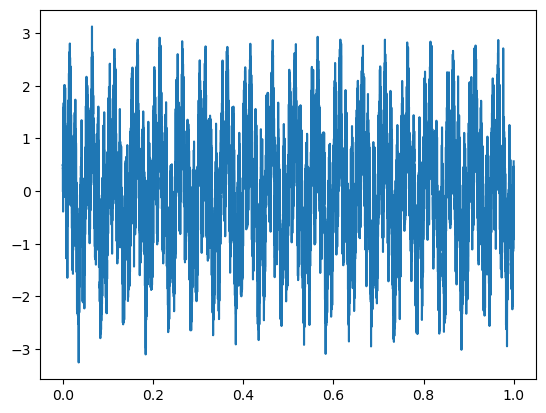

In [5]:
t = np.linspace(0,1,10000, endpoint = False)
# желаемый сигнал
desired = np.sin(2*np.pi*20*t)
# сигнал на входе
sig = desired + 0.5*np.random.randn(len(desired)) + np.sin(2*np.pi*80*t)

plt.plot(t,sig)

In [6]:
X_train = sig[:int(len(sig) * 0.8)]
X_test = sig[int(len(sig) * 0.8):]

Y_train = desired[:int(len(desired) * 0.8)]
Y_test = desired[int(len(desired) * 0.8):]

In [7]:
lms = LMS_filter(alpha=0.1, filt_size = 250)
lms.learn(X_train, Y_train)

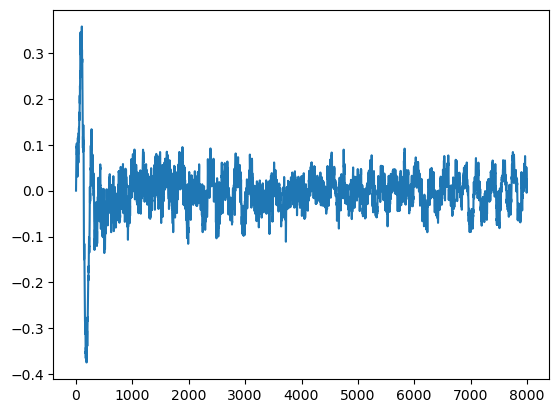

In [8]:
plt.plot(lms.errors)

In [9]:
Y_predict = lfilter(lms.weights,[1],X_test)

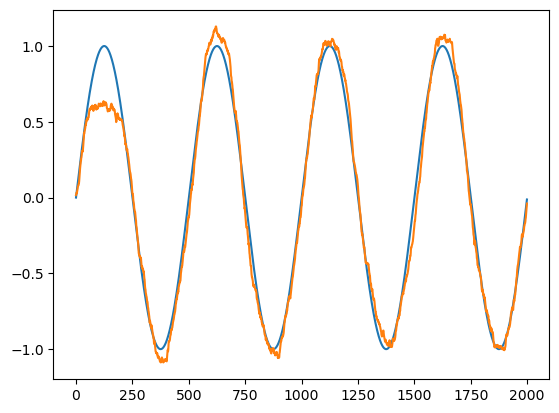

In [10]:
plt.plot(Y_test)
plt.plot(Y_predict)

In [11]:
nlms = LMS_filter(alpha=0.15, filt_size = 300, NLMS = True)
nlms.learn(X_train, Y_train)

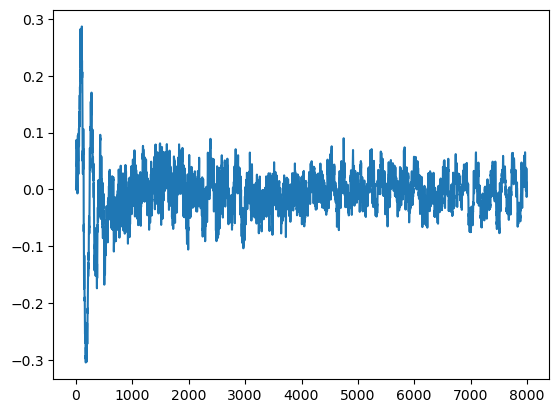

In [12]:
plt.plot(nlms.errors)

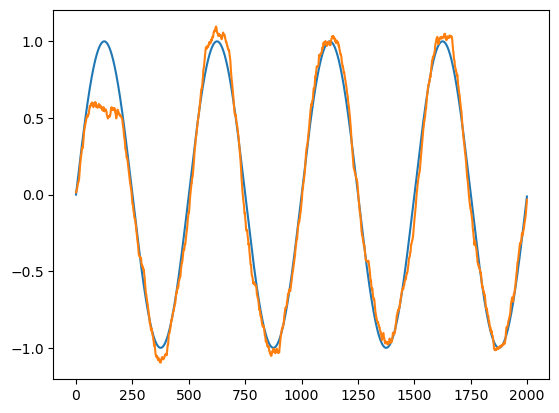

In [13]:
Y_predict = lfilter(nlms.weights,[1],X_test)

plt.plot(Y_test)
plt.plot(Y_predict)

Построим КЧХ полученного фильтра.

(0.0, 500.0)

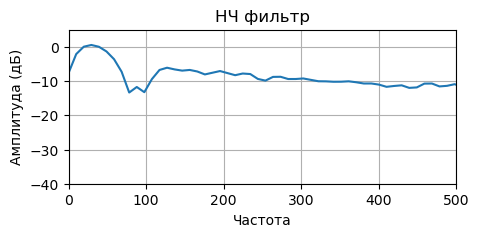

In [14]:
w,h = freqz(nlms.weights, [1], fs=10000) 

def plot_response(w, h, fs, title):
    plt.figure(figsize=(5,2))
    plt.plot(w, 10*np.log10(np.abs(h)))
    plt.ylim(-40, 5)
    plt.xlim(0, 0.5*fs)
    plt.grid(True)
    plt.xlabel('Частота')
    plt.ylabel('Амплитуда (дБ)')
    plt.title(title)
    
plot_response(w, h, 10000, "НЧ фильтр")
plt.xlim(0, 0.05*10000)

# Задача

Решить ту же задачу с помощью фильтра Винера.

In [17]:
...
weiner_coefs= ...

(0.0, 500.0)

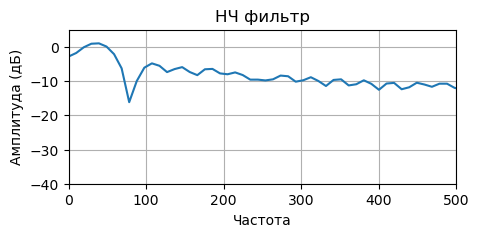

In [19]:
w,h = freqz(weiner_coefs, [1], fs=10000) 

def plot_response(w, h, fs, title):
    plt.figure(figsize=(5,2))
    plt.plot(w, 10*np.log10(np.abs(h)))
    plt.ylim(-40, 5)
    plt.xlim(0, 0.5*fs)
    plt.grid(True)
    plt.xlabel('Частота')
    plt.ylabel('Амплитуда (дБ)')
    plt.title(title)
    
plot_response(w, h, 10000, "НЧ фильтр")
plt.xlim(0, 0.05*10000)

In [20]:
from scipy.signal import lfilter
s_hat = lfilter(weiner_coefs,[1],X_test)

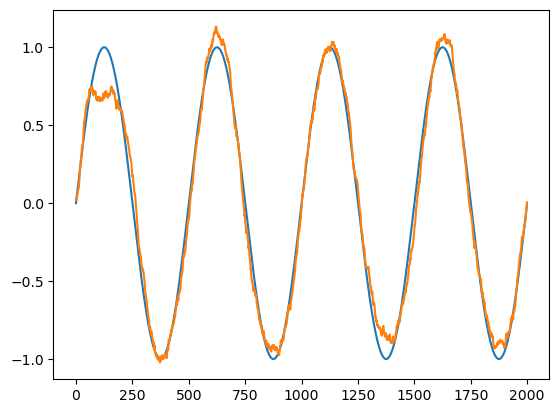

In [21]:
plt.plot(Y_test)
plt.plot(s_hat)

# Пример 2

Рассмотрим задачу идентификации ЛС системы.

In [22]:
# сигнал
sig_in = np.load('speech.npy')

# Некий фильтр с коэффициентами, который мы хотим определить
coeffs = np.concatenate(([0.8], np.zeros(8), [-0.7], np.zeros(9),
                         [0.5], np.zeros(11), [-0.3], np.zeros(3),
                         [0.1], np.zeros(20), [-0.05]))


# результат прохождения сигнала через фильтр
sig_out = lfilter(coeffs, [1], sig_in)

# добавление шума
noise = np.random.randn(len(sig_out)) * np.sqrt(5000)
sig_out += noise

In [14]:
np.max(np.abs(sig_in))

31576.07933976136

In [7]:
import IPython
IPython.display.Audio(sig_in,rate=11025)

In [8]:
IPython.display.Audio(sig_out,rate=11025)

Text(0.5, 0, 'Отсчёты')

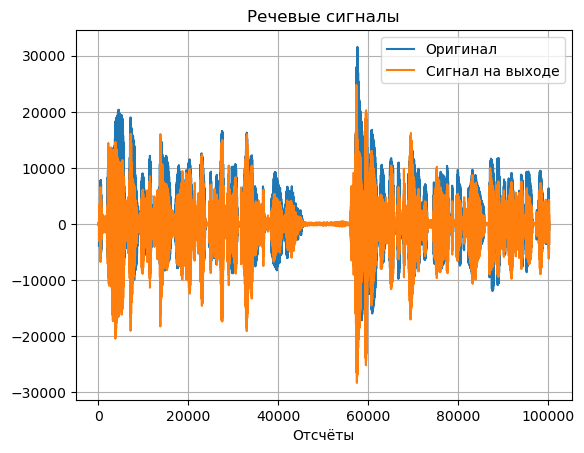

In [9]:
plt.figure()
plt.title("Речевые сигналы")
plt.plot(sig_in, label="Оригинал")
plt.plot(sig_out, label="Сигнал на выходе")
plt.grid()
plt.legend()
plt.xlabel('Отсчёты')

In [10]:
nlms = LMS_filter(alpha=0.1, filt_size = 100, NLMS = True)
y_filt = nlms.learn(sig_in, sig_out, True)

In [11]:
import IPython
IPython.display.Audio(y_filt,rate=11025)

Text(0.5, 0, 'Отсчёты')

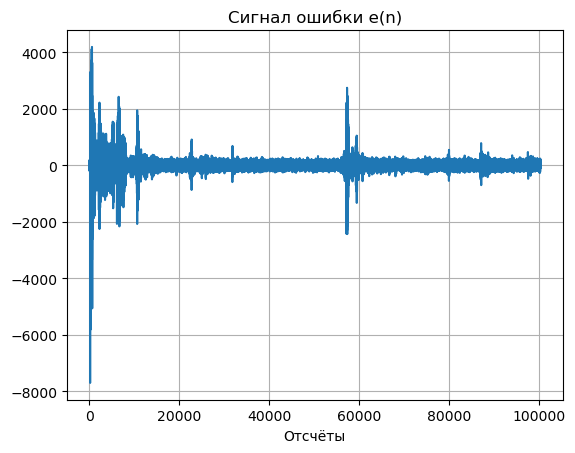

In [12]:
# График ошибки
plt.figure()
plt.title('Сигнал ошибки e(n)')
plt.plot(nlms.errors)
plt.grid()
plt.xlabel('Отсчёты')

Убедимся, что построенный фильтр действительно приближает ЛС систему.

Text(0.5, 0, 'Отсчёты')

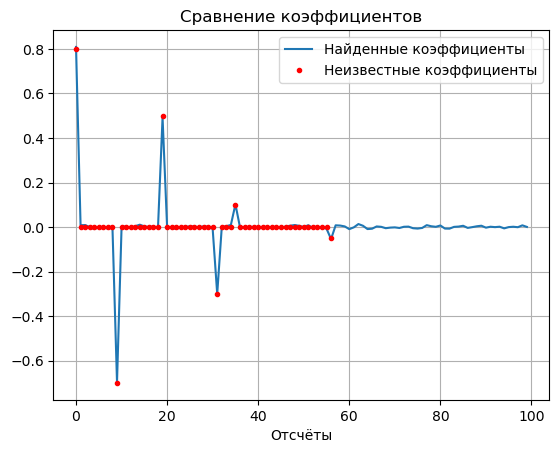

In [15]:
plt.figure()
plt.title('Сравнение коэффициентов')
plt.plot(nlms.weights,  label = 'Найденные коэффициенты')
plt.plot(coeffs, 'r.', label='Неизвестные коэффициенты')
plt.grid()
plt.legend()
plt.xlabel('Отсчёты')